# Notebook setup: modules and functions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import xarray as xr
from netCDF4 import Dataset # Because we will change the netCDF files on disk in some cases
import numpy as np                
import os, subprocess
from shutil import copy2

# User directory configuration 

In [2]:
# Location of RTE+RRTMGP distribution directory
# Default is ~/Codes/rte-rrtmgp 
rte_rrtmgp_dir  = os.path.expanduser("~") + "/Codes/rte-rrtmgp/"

# Location of testing/validation directory, used to obtain un-tuned absorption coefficients 
# Default is ~/Codes/RRTMGP/trunk/
rrtmgp_test_dir = os.path.expanduser("~") + "/Codes/RRTMGP/trunk/"

In [3]:
# https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')   

def copyVar(nc_in, nc_out, name) :
    nc_out.createVariable(name, nc_in.variables[name].dtype, nc_in.variables[name].dimensions)
    nc_out.variables[name].setncatts(nc_in.variables[name].__dict__)
    nc_out.variables[name][:] = nc_in.variables[name][:]

def plot_err_distribution(fig, axes, quantity, location, ref_file, test_files, test_labels):
    """Plot the difference in 'quantity' at 'location' between a reference and one or more tests"""
    ref_ds = xr.open_dataset(ref_file)
    tst_ds = [xr.open_dataset(f) for f in test_files]

    ref = ref_ds.variables[quantity][location,:]
    errs = [tf.variables[quantity][location,:] - ref for tf in tst_ds]
    ref_ds.close()
    [tf.close() for tf in tst_ds]

    sb.boxplot(data = errs)
    sb.swarmplot(data = errs, color = "0.25")
    axes.set_ylabel("Error (W/m2)")
    axes.set_xticklabels(test_labels)
    axes.axhline()
    
def plot_max_vert_err_distribution(fig, axes, quantity, ref_file, test_files, test_labels, factor=1., yaxisunits="W/m2"):
    ref_ds = xr.open_dataset(ref_file)
    tst_ds = [xr.open_dataset(f) for f in test_files]
    vaxis = "lay" if "lay" in ref_ds.variables[quantity].dims else "lev"
    
    ref = ref_ds.variables[quantity][:]
    errs = [(tf.variables[quantity][:] - ref).max(dim=vaxis)*factor for tf in tst_ds]
    ref_ds.close()
    [tf.close() for tf in tst_ds]

    sb.boxplot(data = errs)
    sb.swarmplot(data = errs, color = "0.25")
    axes.set_ylabel("Max error (" +  yaxisunits +")")
    axes.set_xticklabels(test_labels)
    axes.axhline()    

In [4]:
fig_size = 95 

# Data from external calculations

# RRTMGP calculations

In [5]:
#
# Results from LBLRTM and RRTMG 
#
lw_lblrtm_file = 'data/lblrtm-v12.8-lw-flux-inputs-outputs-garand-r1378.nc'
lw_rrtmg_file  = "data/" + "rrtmg-lw-inputs-outputs_alb_0.2_sza_30.nc"
sw_lblrtm_file = 'data/lblrtm-v12.8-sw-dirbeam-flux-inputs-outputs-garand-r1378.nc'
sw_charts_file = 'data/charts-sw-inputs-outputs-clear_alb0_sza30.nc'
sw_rrtmg_file  = "data/" + "rrtmg-sw-inputs-outputs_alb_0.0_sza_30.nc"
#
# Location of surface, top-of-atmosphere
#
lw_lblrtm = xr.open_dataset(lw_lblrtm_file)
toa = (lw_lblrtm.variables['p_lev'][:]).argmin(dim="lev")
sfc = (lw_lblrtm.variables['p_lev'][:]).argmax(dim="lev")
lw_lblrtm.close()
#
# heating rates in RRTMG files are in K/d; modify to K/s
# net flux is negative in SW file
#
copy2(lw_rrtmg_file, "data/" + "rrtmg-lw-inputs-outputs.nc")
lw_rrtmg_file = "data/" + "rrtmg-lw-inputs-outputs.nc"
copy2(sw_rrtmg_file, "data/" + "rrtmg-sw-inputs-outputs.nc")
sw_rrtmg_file = "data/" + "rrtmg-sw-inputs-outputs.nc"
for f in [sw_rrtmg_file, lw_rrtmg_file]: 
    x = Dataset(f, 'a')
    x.variables["heating_rate"][:] = x.variables["heating_rate"][:]/86400.
    x.close()
for f in [sw_rrtmg_file]: 
    x = Dataset(f, 'a')
    x.variables["flux_net"][:] = -x.variables["flux_net"][:]
    x.close()


In [6]:
#
# Set up the ability to calculate fluxes with RRTMGP
#   Build the RTE+RRMTGP library
#   This relies on users have set up a Makefile.conf in rte_rrtmgp_dir + "build/" or 
#   having defined variables FC and FCFLAGS in the environment 
#
subprocess.run(["export RRTMGP_ROOT=" + rte_rrtmgp_dir + "; " + \
                "cd " + rte_rrtmgp_dir + "build/; make "], shell=True)
#
# Build the program that computes fluxes from netCDF Garand atmosphere files
#   Users will need to have edited "Makefile" to point to netCDF include files and 
#   C and Fortran libraries 
# 
subprocess.run(["export RRTMGP_ROOT=" + rte_rrtmgp_dir + "; make "], shell=True)
flux_exe_name   = "rrtmgp_garand_atmos"

#
# Coefficient files, executable for Garand atmospheres
#
copy2(rte_rrtmgp_dir + "rrtmgp/data/coefficients_lw.nc", "data/")
copy2(rte_rrtmgp_dir + "rrtmgp/data/coefficients_sw.nc", "data/")
copy2(rrtmgp_test_dir + "data/coefficents_lw_noscaling.nc", "data/coefficients_lw_noscaling.nc")
copy2(rrtmgp_test_dir + "data/coefficients_sw_noscaling.nc", "data/")

'data/coefficients_sw_noscaling.nc'

In [7]:
#
# RRTMGP calculations 
#

#
# Compute RRTMGP LW and SW solution
#
sw_rrtmgp_default_file = "data/" + "rrtmgp-sw-inputs-outputs-default.nc"
sw_rrtmgp_untuned_file = "data/" + "rrtmgp-sw-inputs-outputs-untuned.nc"
lw_rrtmgp_default_file = "data/" + "rrtmgp-lw-inputs-outputs-default.nc"
lw_rrtmgp_untuned_file = "data/" + "rrtmgp-lw-inputs-outputs-untuned.nc"

copy2(sw_charts_file, sw_rrtmgp_default_file)
copy2(sw_charts_file, sw_rrtmgp_untuned_file)
copy2(lw_lblrtm_file, lw_rrtmgp_default_file)
copy2(lw_lblrtm_file, lw_rrtmgp_untuned_file)

# Compute three-angle solutions - use the LBLRTM setup but remove the 
#   angle dimension and any variables that use it, then create a new
#   angle dimension of length 3 (this is how the RRTMGP driver knows 
#   how many quadrature angles to use)
#

lw_rrtmgp_3ang_default_file = "data/" + "rrtmgp-lw-inputs-outputs-3angle-default.nc"
lw_rrtmgp_3ang_untuned_file = "data/" + "rrtmgp-lw-inputs-outputs-3angle-untuned.nc"

varsToDel = ['angle', 'angle_secant', 'angle_weight']
dimsToDel = ['angle']

for fn in [lw_rrtmgp_3ang_default_file, lw_rrtmgp_3ang_untuned_file]:
  f    = Dataset(fn, 'w')
  oldF = Dataset(lw_lblrtm_file)  
  for d in oldF.dimensions: 
    if not d in dimsToDel: f.createDimension(oldF.dimensions[d].name, oldF.dimensions[d].size)
  for v in oldF.variables:  
    if not v in varsToDel: copyVar(oldF, f, v)
  oldF.close()
  f.createDimension("angle", 3)
  f.close()

subprocess.run(["./" + flux_exe_name, sw_rrtmgp_default_file, "data/coefficients_sw.nc"])
subprocess.run(["./" + flux_exe_name, sw_rrtmgp_untuned_file, "data/coefficients_sw_noscaling.nc"])
subprocess.run(["./" + flux_exe_name, lw_rrtmgp_3ang_default_file, "data/coefficients_lw.nc"])
subprocess.run(["./" + flux_exe_name, lw_rrtmgp_3ang_untuned_file, "data/coefficients_lw_noscaling.nc"])
subprocess.run(["./" + flux_exe_name, lw_rrtmgp_default_file, "data/coefficients_lw.nc"])
subprocess.run(["./" + flux_exe_name, lw_rrtmgp_untuned_file, "data/coefficients_lw_noscaling.nc"])

CompletedProcess(args=['./rrtmgp_garand_atmos', 'data/rrtmgp-lw-inputs-outputs-untuned.nc', 'data/coefficients_lw_noscaling.nc'], returncode=0)

# Assessing the k-distribution

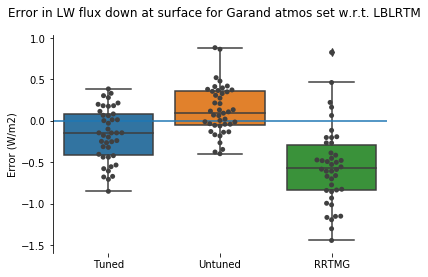

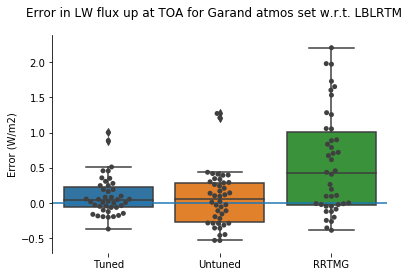

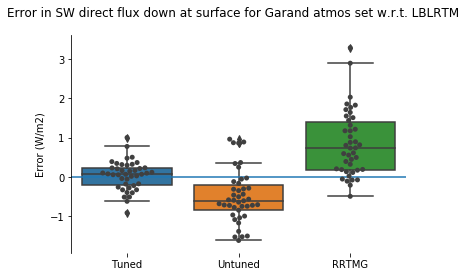

In [8]:
#
# Assessing the k-distribution: 
#  LW: three-angle solutions at TOA and SFC
#  use RRMTG too because tuned diffusivity angle 
#
spines_to_remove        = ['top', 'right', 'bottom'] 

fig = plt.figure()
axes = fig.add_subplot(111)
plot_err_distribution(fig, axes, "flux_dn", sfc, lw_lblrtm_file, \
                      [lw_rrtmgp_3ang_default_file, lw_rrtmgp_3ang_untuned_file, lw_rrtmg_file], \
                      ["Tuned", "Untuned", "RRTMG"])
fig.suptitle("Error in LW flux down at surface for Garand atmos set w.r.t. LBLRTM")
for spine in spines_to_remove: axes.spines[spine].set_visible(False)
plt.savefig("lw-sfc-kdist-tuning.pdf", dpi=600)

fig = plt.figure()
axes = fig.add_subplot(111)
plot_err_distribution(fig, axes, "flux_up", toa, lw_lblrtm_file, \
                      [lw_rrtmgp_3ang_default_file, lw_rrtmgp_3ang_untuned_file, lw_rrtmg_file], \
                      ["Tuned", "Untuned", "RRTMG"])
for spine in spines_to_remove: axes.spines[spine].set_visible(False)
fig.suptitle("Error in LW flux up at TOA for Garand atmos set w.r.t. LBLRTM")
plt.savefig("lw-toa-kdist-tuning.pdf", dpi=600)

#
#  SW: direct beam at SFC
#    do this for tuned and untuned coefficient files 
#  use RRMTG too
#
fig = plt.figure()
axes = fig.add_subplot(111)
plot_err_distribution(fig, axes, "flux_dir_dn", sfc, sw_charts_file, \
                      [sw_rrtmgp_default_file, sw_rrtmgp_untuned_file, sw_rrtmg_file], \
                      ["Tuned", "Untuned", "RRTMG"])
for spine in spines_to_remove: axes.spines[spine].set_visible(False)
fig.suptitle("Error in SW direct flux down at surface for Garand atmos set w.r.t. LBLRTM")
plt.savefig("sw-sfc-kdist-tuning.pdf", dpi=600)

# Flux errors

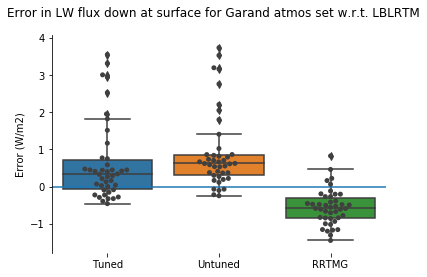

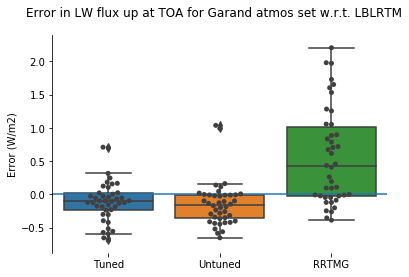

In [9]:
fig = plt.figure()
axes = fig.add_subplot(111)
plot_err_distribution(fig, axes, "flux_dn", sfc, lw_lblrtm_file, \
                      [lw_rrtmgp_default_file, lw_rrtmgp_untuned_file, lw_rrtmg_file], \
                      ["Tuned", "Untuned", "RRTMG"])
for spine in spines_to_remove: axes.spines[spine].set_visible(False)
fig.suptitle("Error in LW flux down at surface for Garand atmos set w.r.t. LBLRTM")
plt.savefig("lw-sfc-total-error.pdf", dpi=600)

fig = plt.figure()
axes = fig.add_subplot(111)
plot_err_distribution(fig, axes, "flux_up", toa, lw_lblrtm_file, \
                      [lw_rrtmgp_default_file, lw_rrtmgp_untuned_file, lw_rrtmg_file], \
                      ["Tuned", "Untuned", "RRTMG"])
for spine in spines_to_remove: axes.spines[spine].set_visible(False)
fig.suptitle("Error in LW flux up at TOA for Garand atmos set w.r.t. LBLRTM")
plt.savefig("lw-toa-total-error.pdf", dpi=600)


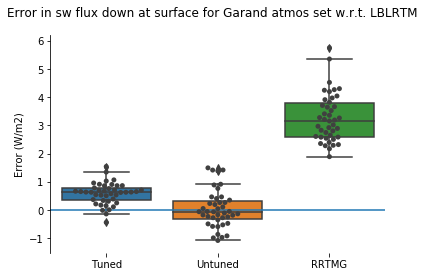

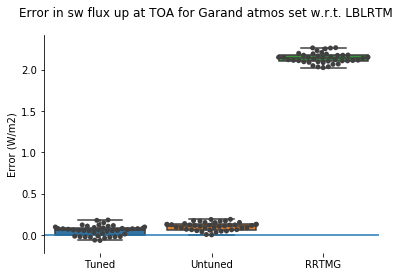

In [10]:
fig = plt.figure()
axes = fig.add_subplot(111)
plot_err_distribution(fig, axes, "flux_dn", sfc, sw_charts_file, \
                      [sw_rrtmgp_default_file, sw_rrtmgp_untuned_file, sw_rrtmg_file], \
                      ["Tuned", "Untuned", "RRTMG"])
for spine in spines_to_remove: axes.spines[spine].set_visible(False)
fig.suptitle("Error in sw flux down at surface for Garand atmos set w.r.t. LBLRTM")
plt.savefig("sw-sfc-total-error.pdf", dpi=600)

fig = plt.figure()
axes = fig.add_subplot(111)
plot_err_distribution(fig, axes, "flux_up", toa, sw_charts_file, \
                      [sw_rrtmgp_default_file, sw_rrtmgp_untuned_file, sw_rrtmg_file], \
                      ["Tuned", "Untuned", "RRTMG"])
for spine in spines_to_remove: axes.spines[spine].set_visible(False)
fig.suptitle("Error in sw flux up at TOA for Garand atmos set w.r.t. LBLRTM")
plt.savefig("sw-toa-total-error.pdf", dpi=600)


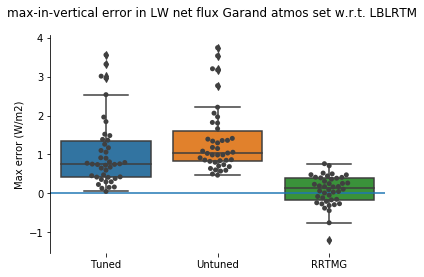

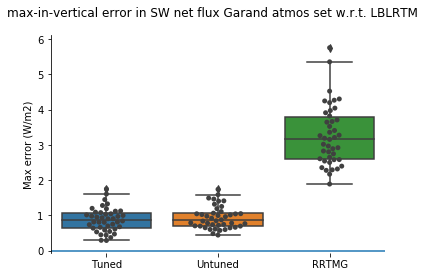

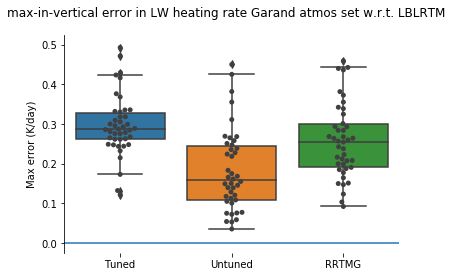

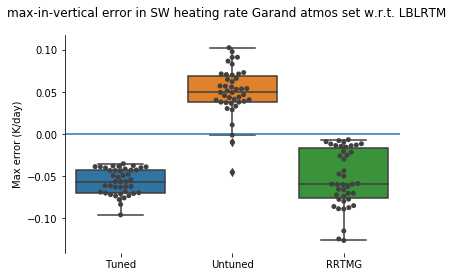

In [11]:
fig = plt.figure()
axes = fig.add_subplot(111)
plot_max_vert_err_distribution(fig, axes, "flux_net", lw_lblrtm_file, \
                      [lw_rrtmgp_default_file, lw_rrtmgp_untuned_file, lw_rrtmg_file], \
                      ["Tuned", "Untuned", "RRTMG"])
for spine in spines_to_remove: axes.spines[spine].set_visible(False)
fig.suptitle("max-in-vertical error in LW net flux Garand atmos set w.r.t. LBLRTM")
plt.savefig("lw-error-net.pdf", dpi=600)

fig = plt.figure()
axes = fig.add_subplot(111)
plot_max_vert_err_distribution(fig, axes, "flux_net", sw_charts_file, \
                      [sw_rrtmgp_default_file, sw_rrtmgp_untuned_file, sw_rrtmg_file], \
                      ["Tuned", "Untuned", "RRTMG"])
for spine in spines_to_remove: axes.spines[spine].set_visible(False)
fig.suptitle("max-in-vertical error in SW net flux Garand atmos set w.r.t. LBLRTM")
plt.savefig("sw-error-net.pdf", dpi=600)

fig = plt.figure()
axes = fig.add_subplot(111)
plot_max_vert_err_distribution(fig, axes, "heating_rate", lw_lblrtm_file, \
                      [lw_rrtmgp_default_file, lw_rrtmgp_untuned_file, lw_rrtmg_file], \
                      ["Tuned", "Untuned", "RRTMG"], factor=86400.,yaxisunits="K/day")
for spine in spines_to_remove: axes.spines[spine].set_visible(False)
fig.suptitle("max-in-vertical error in LW heating rate Garand atmos set w.r.t. LBLRTM")
plt.savefig("lw-error-hr.pdf", dpi=600)

fig = plt.figure()
axes = fig.add_subplot(111)
plot_max_vert_err_distribution(fig, axes, "heating_rate", sw_charts_file, \
                      [sw_rrtmgp_default_file, sw_rrtmgp_untuned_file, sw_rrtmg_file], \
                      ["Tuned", "Untuned", "RRTMG"], factor=86400.,yaxisunits="K/day")
for spine in spines_to_remove: axes.spines[spine].set_visible(False)
fig.suptitle("max-in-vertical error in SW heating rate Garand atmos set w.r.t. LBLRTM")
plt.savefig("sw-error-hr.pdf", dpi=600)